# Importing all necessary packages

In [341]:
import numpy as np 
import pandas as pd 

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import scipy as sp
import scipy.optimize

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'w'
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Task A:

## Imbalance Data and it's effects on SVM and Logistic Regression

In [342]:
def draw_line(coef,intercept, mi, ma):
    # for the separating hyper plane ax+by+c=0, the weights are [a, b] and the intercept is c
    # to draw the hyper plane we are creating two points
    # 1. ((b*min-c)/a, min) i.e ax+by+c=0 ==> ax = (-by-c) ==> x = (-by-c)/a here in place of y we are keeping the minimum value of y
    # 2. ((b*max-c)/a, max) i.e ax+by+c=0 ==> ax = (-by-c) ==> x = (-by-c)/a here in place of y we are keeping the maximum value of y
    points=np.array([[((-coef[1]*mi - intercept)/coef[0]), mi],[((-coef[1]*ma - intercept)/coef[0]), ma]])
    plt.plot(points[:,0], points[:,1])

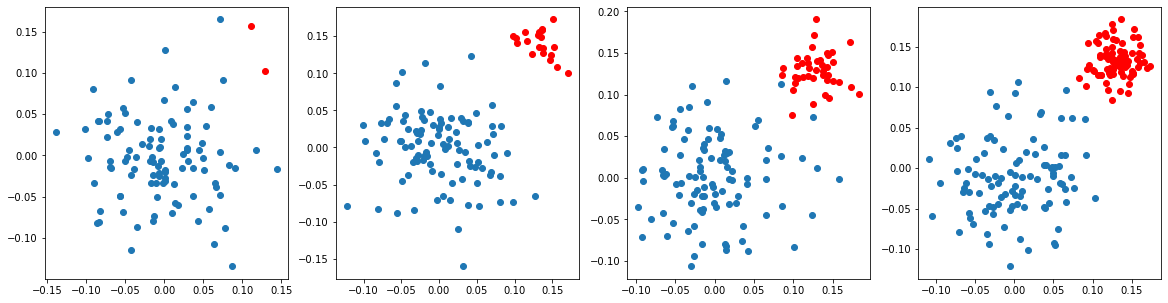

In [343]:
# here we are creating 2d imbalanced data points 
ratios = [(100,2), (100, 20), (100, 40), (100, 80)]
plt.figure(figsize=(20,5))
for j,i in enumerate(ratios):
    plt.subplot(1, 4, j+1)
    X_p=np.random.normal(0,0.05,size=(i[0],2))
    X_n=np.random.normal(0.13,0.02,size=(i[1],2))
    y_p=np.array([1]*i[0]).reshape(-1,1)
    y_n=np.array([0]*i[1]).reshape(-1,1)
    X=np.vstack((X_p,X_n))
    y=np.vstack((y_p,y_n))
    plt.scatter(X_p[:,0],X_p[:,1])
    plt.scatter(X_n[:,0],X_n[:,1],color='red')
plt.show()

### Applying on SVM

<Figure size 1440x360 with 0 Axes>

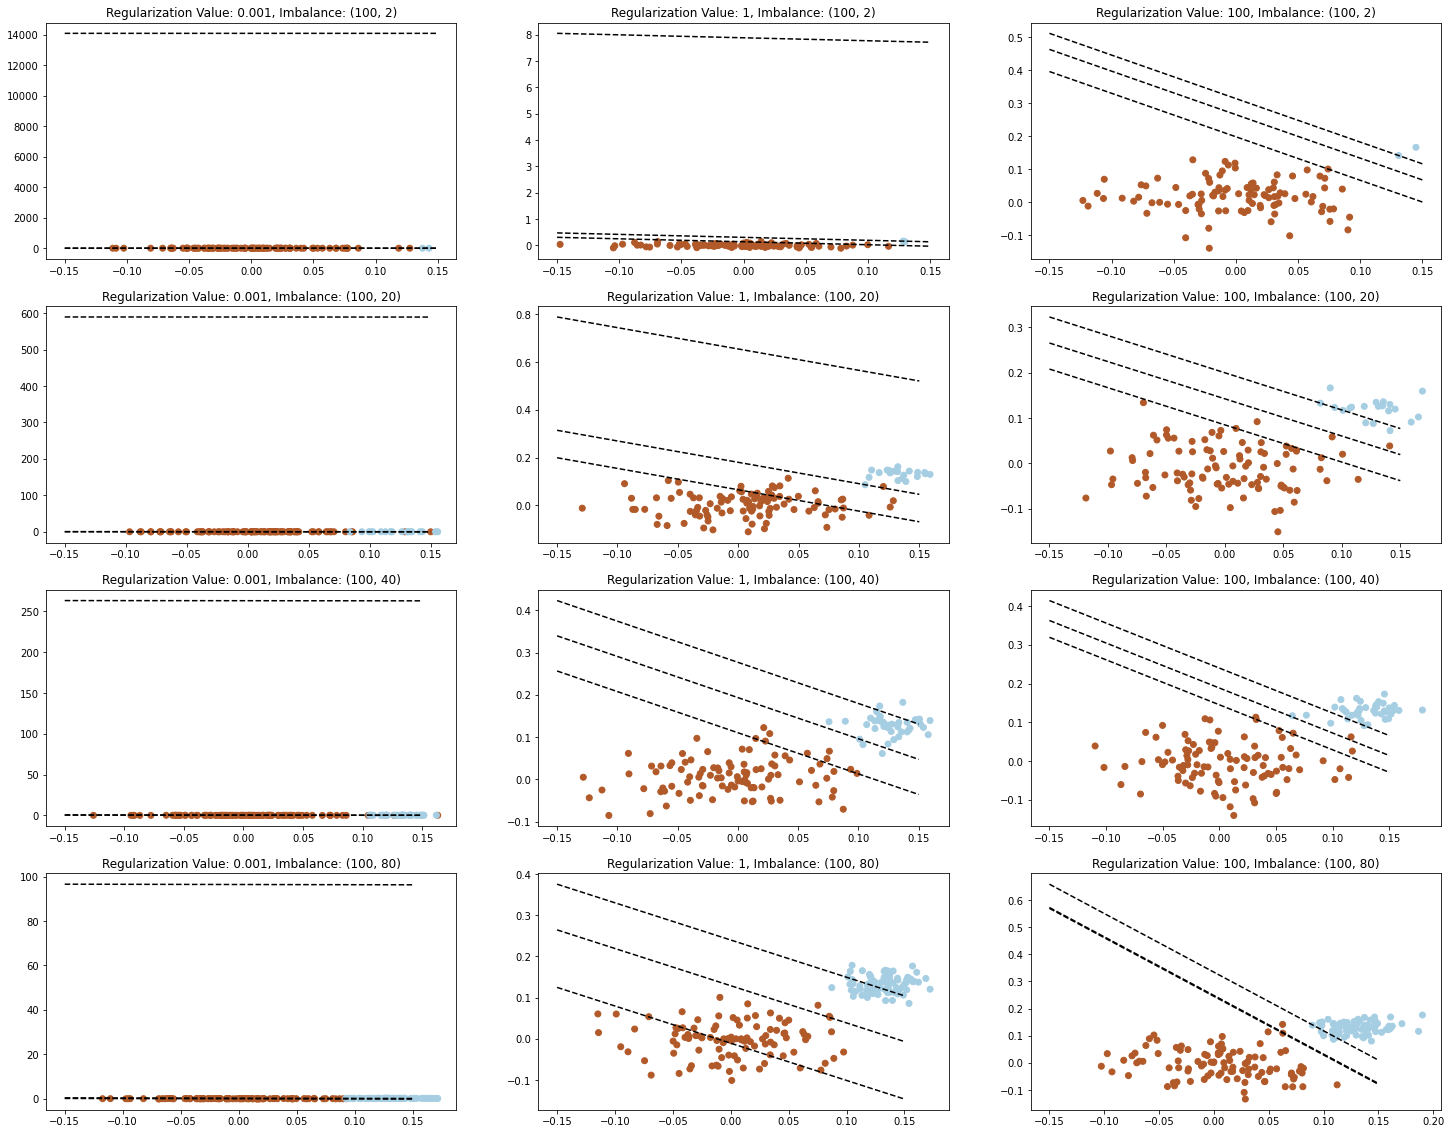

In [344]:
# ref: https://scikit-learn.org/0.15/auto_examples/svm/plot_separating_hyperplane.html

reg_strengths = [0.001,1,100]
ratios = [(100,2), (100, 20), (100, 40), (100, 80)]
plt.figure(figsize=(20,5))
fig, axs = plt.subplots(4, 3, figsize=(25, 20))
for p,r in enumerate(reg_strengths):
    for j,i in enumerate(ratios):
        # plt.subplot(4, 3, j+1)

        X_p=np.random.normal(0,0.05,size=(i[0],2))
        X_n=np.random.normal(0.13,0.02,size=(i[1],2))
        y_p=np.array([1]*i[0]).reshape(-1,1)
        y_n=np.array([0]*i[1]).reshape(-1,1)
        X=np.vstack((X_p,X_n))
        y=np.vstack((y_p,y_n))

        clf = SVC(kernel="linear", C=r)
        clf.fit(X,y)
        
        # get the separating hyperplane
        w = clf.coef_[0]
        a = -w[0] / w[1]
        # xx = np.linspace(-5,5)
        xx = np.linspace(-0.15, 0.15)
        yy = a * xx - (clf.intercept_[0]) / w[1]

        # plot the parallels to the separating hyperplane that pass through the
        # support vectors
        b = clf.support_vectors_[0]
        yy_down = a * xx + (b[1] - a * b[0])
        b = clf.support_vectors_[-1]
        yy_up = a * xx + (b[1] - a * b[0])

        # plot the line, the points, and the nearest vectors to the plane
        axs[j, p].plot(xx, yy, 'k--')
        axs[j, p].plot(xx, yy_down, 'k--')
        axs[j, p].plot(xx, yy_up, 'k--')

        axs[j, p].scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                    s=80, facecolors='none')
        axs[j, p].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

        axs[j, p].axis('tight')
        axs[j, p].set_title(f"Regularization Value: {r}, Imbalance: {i}")

plt.show()

## Observations: 
When the value of c is 0.001, the hyperplane could not differentiate the points, irrespective of the imbalance. 

When the value of c is 1, the hyperplane could not differentiate when the imbalance is (100,2). It was able to do a slightly better job in the other imbalances. 

When the value of c is 100, the hyperplane was able to differentiate in all imbalances. 

## Applying on Logistic Regression

<Figure size 1440x360 with 0 Axes>

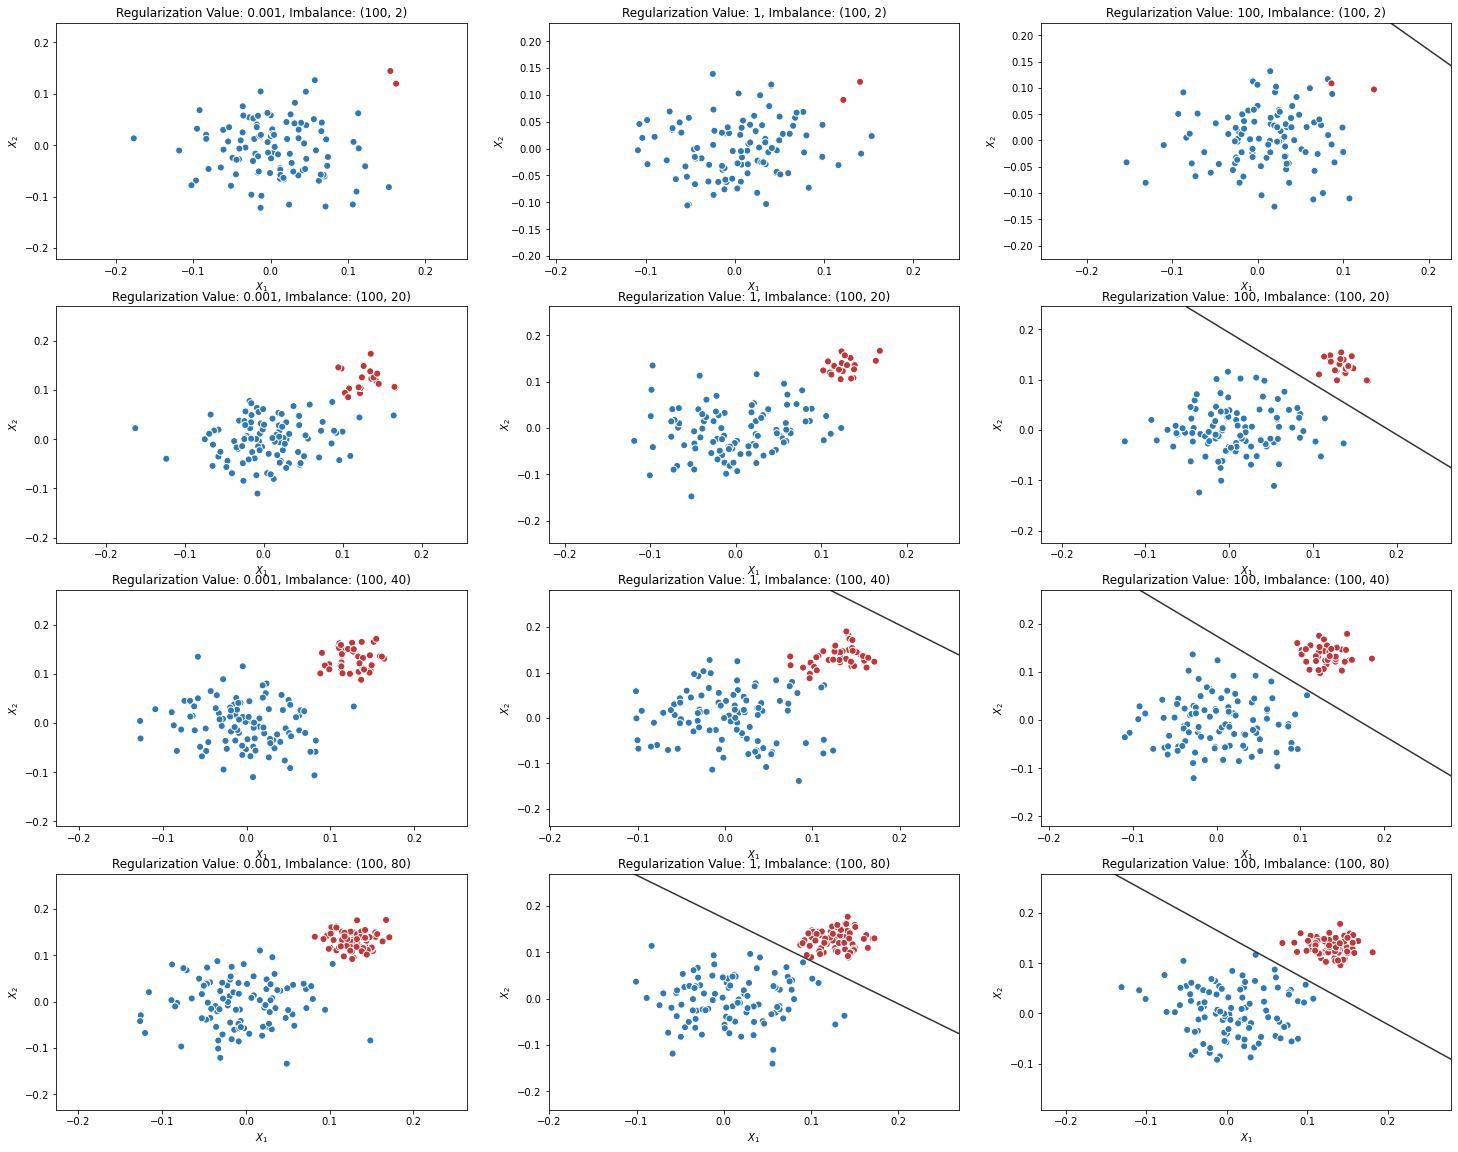

In [345]:
# ref: https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression

reg_strengths = [0.001,1,100]
ratios = [(100,2), (100, 20), (100, 40), (100, 80)]
plt.figure(figsize=(20,5))
fig, axs = plt.subplots(4, 3, figsize=(25, 20))
# inc = 1
for p,r in enumerate(reg_strengths):
    for j,i in enumerate(ratios):
        X_p=np.random.normal(0,0.05,size=(i[0],2))
        X_n=np.random.normal(0.13,0.02,size=(i[1],2))
        y_p=np.array([1]*i[0]).reshape(-1,1)
        y_n=np.array([0]*i[1]).reshape(-1,1)
        X=np.vstack((X_p,X_n))
        y=np.vstack((y_p,y_n))

        clf = LogisticRegression(C=r)
        clf.fit(X, y)     

        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

        xx, yy = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
        grid = np.c_[xx.ravel(), yy.ravel()]

        probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

        axs[j, p].contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

        axs[j, p].scatter(X[:,0], X[:, 1], c=y[:], s=50,
                cmap="RdBu", vmin=-.2, vmax=1.2,
                edgecolor="white", linewidth=1)

        axs[j, p].set(aspect="equal",
            xlim=(x_min, x_max), ylim=(y_min, y_max),
            xlabel="$X_1$", ylabel="$X_2$")

        axs[j, p].axis('tight')
        axs[j, p].set_title(f"Regularization Value: {r}, Imbalance: {i}")


## Observations:

When the value of c is 0.01, the model is not able to seperate irrespective of the imbalance value.

When the value of c is 1, the model is only able to seperate when the imbalance is 100:80 i.e., almost balanced dataset.

When the value of c is 100, the model is able to seperate in almost all of the cases except highly imbalanced dataset 100:2. 

# Task B

## Features with varying variance and standardizations effect's on SVM and Logistic Regresssion

In [346]:
data = pd.read_csv('/WData/cS/AAIC/Assignments/Behaviour of Linear Models/task_b.csv')
data=data.iloc[:,1:]

In [347]:
data.head()

,f1,f2,f3,y
0,-195.871045,-14843.084171,5.532140,1.0
1,-1217.183964,-4068.124621,4.416082,1.0
2,9.138451,4413.412028,0.425317,0.0
3,363.824242,15474.760647,1.094119,0.0
4,-768.812047,-7963.932192,1.870536,0.0


In [348]:
data.corr()['y']

f1    0.067172
f2   -0.017944
f3    0.839060
y     1.000000
Name: y, dtype: float64

In [349]:
data.std()

f1      488.195035
f2    10403.417325
f3        2.926662
y         0.501255
dtype: float64

In [350]:
X=data[['f1','f2','f3']].values
Y=data['y'].values
print(X.shape)
print(Y.shape)

(200, 3)
(200,)


In [351]:
X_std, Y_std = np.zeros_like(X), np.zeros_like(Y)
for i in range(len(X[0])):
    X_std[:, i] = (X[:, i]-X[:,i].mean())/X[:,i].std()
Y_std = (Y-Y.mean())/Y.std()


Without Standardization: Logistic Regression

Feature 0 Score: 4150.36154	Feature 1 Score: 3035.44894	Feature 2 Score: 11282.99957	

With Standardization: Logistic Regression

Feature 0 Score: 1.58585	Feature 1 Score: 3.30297	Feature 2 Score: 10.68928	

<Figure size 360x720 with 0 Axes>

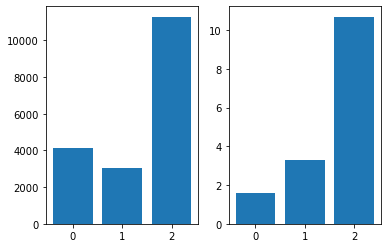

In [352]:
# Reference: https://machinelearningmastery.com/calculate-feature-importance-with-python/
print("\nWithout Standardization: Logistic Regression\n")
plt.figure(figsize=(5,10))
fig, (ax1, ax2) = plt.subplots(1,2)
clf = SGDClassifier(loss="log")
clf.fit(X,Y)
importance = clf.coef_[0]
for i,v in enumerate(importance):
	print('Feature %0d Score: %.5f' % (i,v), end="\t")
ax1.bar([x for x in range(len(importance))], importance)

print("\n\nWith Standardization: Logistic Regression\n")

clf = SGDClassifier(loss="log")
clf.fit(X_std,Y_std)
importance = clf.coef_[0]
for i,v in enumerate(importance):
	print('Feature %0d Score: %.5f' % (i,v), end="\t")
# plot feature importance
ax2.bar([x for x in range(len(importance))], importance)
plt.show()

## Observations:

When the data is not standardized,  the top two features with highest variance, F2 and F3 have almost the same feature importance. 

But, when the data is standardized. F3 has a relatively higher feature importance while the remaining two have low feature importance. 


Without Standardization: SVM

Feature 0 Score: 4294.95327	Feature 1 Score: -13762.66329	Feature 2 Score: 11380.99472	

With Standardization: SVM

Feature 0 Score: 0.19148	Feature 1 Score: 1.60661	Feature 2 Score: 14.48682	

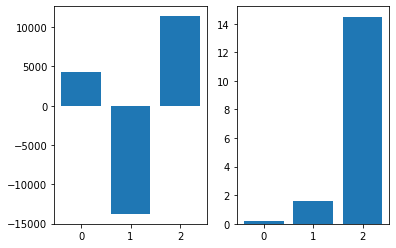

<Figure size 360x720 with 0 Axes>

In [353]:
print("\nWithout Standardization: SVM\n")
fig, (ax1, ax2) = plt.subplots(1,2)
plt.figure(figsize=(5,10))
clf = SGDClassifier(loss="hinge")
clf.fit(X,Y)
importance = clf.coef_[0]
for i,v in enumerate(importance):
	print('Feature %0d Score: %.5f' % (i,v), end="\t")
ax1.bar([x for x in range(len(importance))], importance)

print("\n\nWith Standardization: SVM\n")

clf = SGDClassifier(loss="hinge")
clf.fit(X_std,Y_std)
importance = clf.coef_[0]
for i,v in enumerate(importance):
	print('Feature %0d Score: %.5f' % (i,v), end="\t")
ax2.bar([x for x in range(len(importance))], importance)
plt.show()

## Observations:

When the data is not standardized, feature 2 has the highest feature importance while feature 1 and 3 have almost similar like in logistic regression. 

When the data is standardized, jsut like logistic regression, feature 3 has relatively higher feature importance than feature 1 and 2. 

# Task 3

## Regression Outlier Effect: Visualization best fit Linear Regression for different scenarios

In [354]:
def angles_in_ellipse(num,a,b):
    assert(num > 0)
    assert(a < b)
    angles = 2 * np.pi * np.arange(num) / num
    if a != b:
        e = (1.0 - a ** 2.0 / b ** 2.0) ** 0.5
        tot_size = sp.special.ellipeinc(2.0 * np.pi, e)
        arc_size = tot_size / num
        arcs = np.arange(num) * arc_size
        res = sp.optimize.root(
            lambda x: (sp.special.ellipeinc(x, e) - arcs), angles)
        angles = res.x 
    return angles

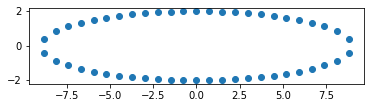

In [355]:
a = 2
b = 9
n = 50

phi = angles_in_ellipse(n, a, b)
e = (1.0 - a ** 2.0 / b ** 2.0) ** 0.5
arcs = sp.special.ellipeinc(phi, e)

fig = plt.figure()
ax = fig.gca()
ax.axes.set_aspect('equal')
ax.scatter(b * np.sin(phi), a * np.cos(phi))
plt.show()

In [356]:
X= b * np.sin(phi)
Y= a * np.cos(phi)

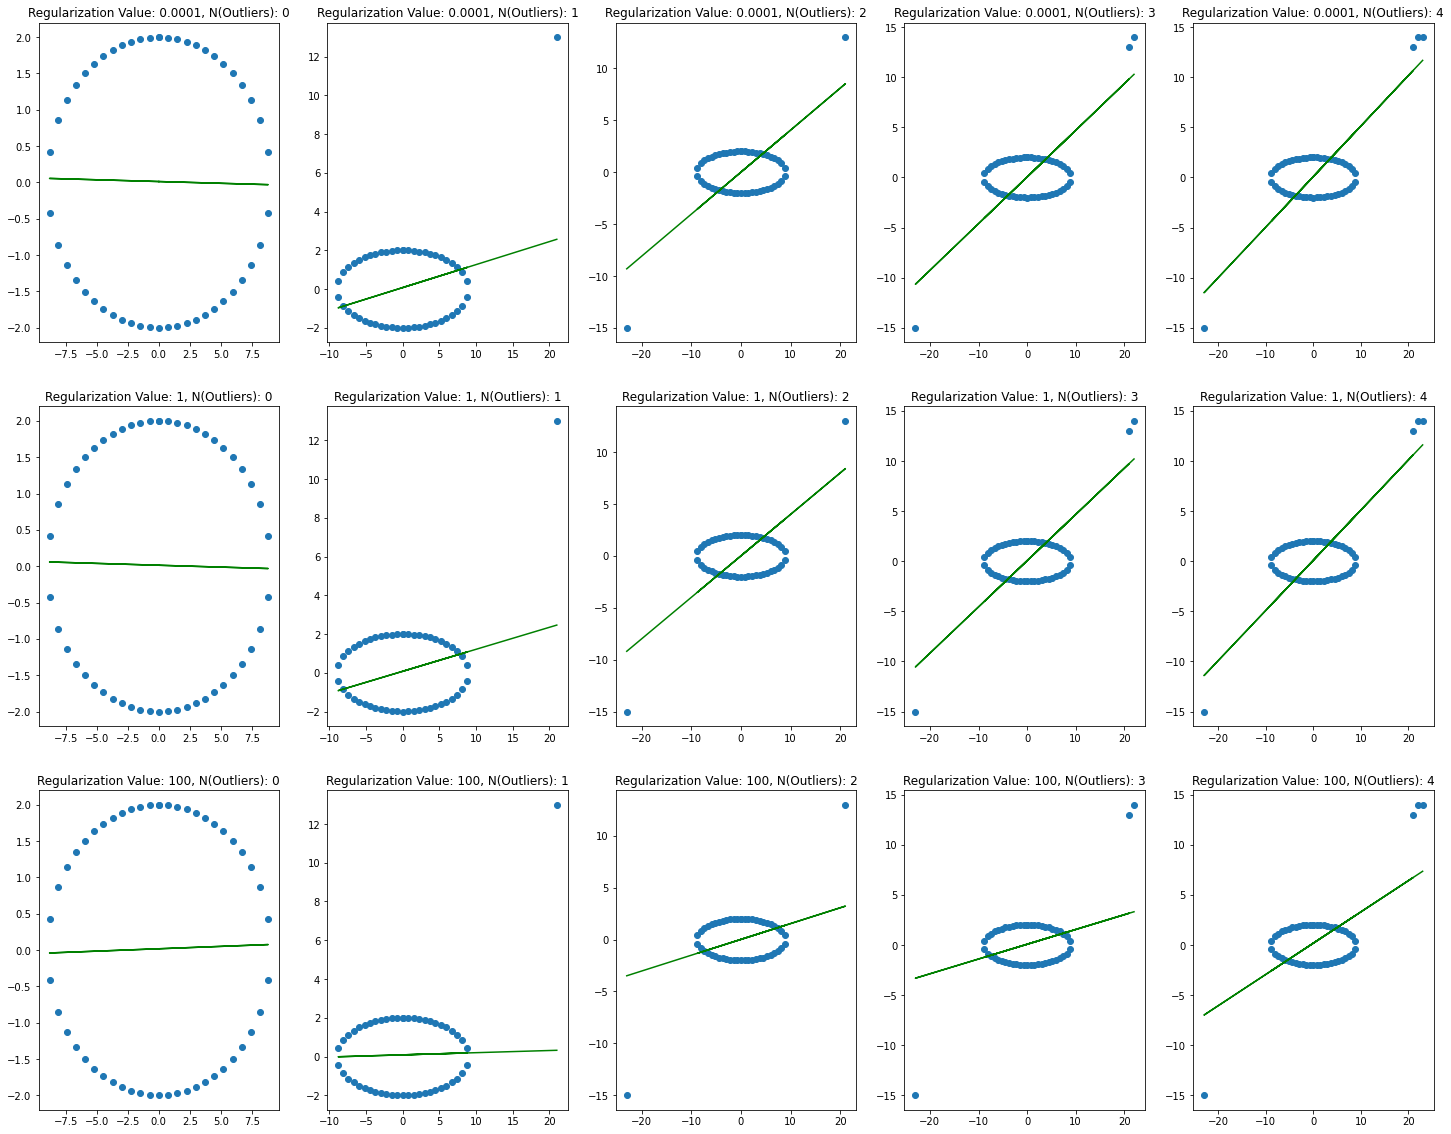

In [357]:
regs = [0.0001, 1, 100] 
outliers = [(0,2),(21, 13), (-23, -15), (22,14), (23, 14)]

x_cp, y_cp = np.copy(X), np.copy(Y)
fig, axs = plt.subplots(3, 5, figsize=(25,20))

for i, r in enumerate(regs):
    for j, o in enumerate(outliers):
        x_cp = np.append(x_cp, o[0])
        y_cp = np.append(y_cp, o[1])
        x_cp = x_cp.reshape(-1,1)
        y_cp = y_cp.reshape(-1,1)
        
        clf = SGDRegressor(alpha=r, eta0=0.001, learning_rate='constant',random_state=0)
        clf.fit(x_cp, y_cp)
        
        y_p = clf.predict(x_cp)
        
        axs[i, j].scatter(x_cp, y_cp)
        axs[i, j].plot(x_cp,y_p, color ='green')
        axs[i, j].axis('tight')
        axs[i, j].set_title(f"Regularization Value: {r}, N(Outliers): {j}")
    x_cp, y_cp = np.copy(X), np.copy(Y)


## Observations:

As the regularization value increases, the tendency to shift towards the outliers decreses. This can be seen in the case where the Regularization Value is 100 and the number of outliers is 4. The decision boundary shifts very little towards the outliers but in the case of same number of outliers with less regularization (0.0001 and 1) the decision boundary shifts towards the outliers

# Task D

## Collinear Features and their effect on Linear Models

In [358]:
data = pd.read_csv('/WData/cS/AAIC/Assignments/Behaviour of Linear Models/task_d.csv')

In [359]:
data.head()

,x,y,z,x*x,2*y,2*z+3*x*x,w,target
0,-0.581066,0.841837,-1.012978,-0.604025,0.841837,-0.665927,-0.536277,0
1,-0.894309,-0.207835,-1.012978,-0.883052,-0.207835,-0.917054,-0.522364,0
2,-1.207552,0.212034,-1.082312,-1.150918,0.212034,-1.166507,0.205738,0
3,-1.364174,0.002099,-0.943643,-1.280666,0.002099,-1.266540,-0.665720,0
4,-0.737687,1.051772,-1.012978,-0.744934,1.051772,-0.792746,-0.735054,0


In [360]:
X = data.drop(['target'], axis=1).values
Y = data['target'].values

<AxesSubplot:>

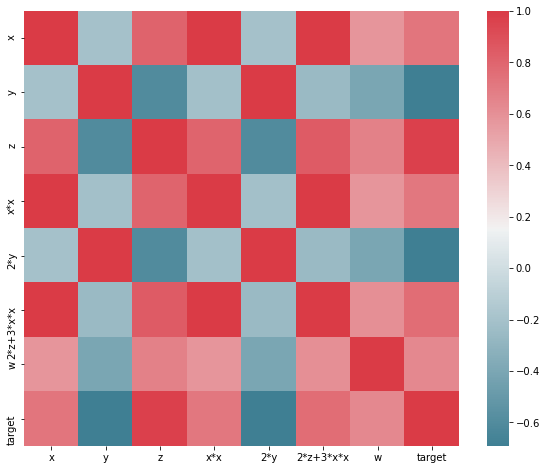

In [361]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [362]:
corr

,x,y,z,x*x,2*y,2*z+3*x*x,w,target
x,1.000000,-0.205926,0.812458,0.997947,-0.205926,0.996252,0.583277,0.728290
y,-0.205926,1.000000,-0.602663,-0.209289,1.000000,-0.261123,-0.401790,-0.690684
z,0.812458,-0.602663,1.000000,0.807137,-0.602663,0.847163,0.674486,0.969990
x*x,0.997947,-0.209289,0.807137,1.000000,-0.209289,0.997457,0.583803,0.719570
2*y,-0.205926,1.000000,-0.602663,-0.209289,1.000000,-0.261123,-0.401790,-0.690684
2*z+3*x*x,0.996252,-0.261123,0.847163,0.997457,-0.261123,1.000000,0.606860,0.764729
w,0.583277,-0.401790,0.674486,0.583803,-0.401790,0.606860,1.000000,0.641750
target,0.728290,-0.690684,0.969990,0.719570,-0.690684,0.764729,0.641750,1.000000


## Observations

Top 2 Features with Highest Correlation with X          :  X*X, 2(Z)+3(X*X)

Top 2 Features with Highest Correlation with Y          :  2*Y, Z

Top 2 Features with Highest Correlation with Z          :  2(Z)+3(X*X), X

Top 2 Features with Highest Correlation with X*X        :  X, 2(Z)+3(X*X)

Top 2 Features with Highest Correlation with 2*Y        :  Y, X

Top 2 Features with Highest Correlation with 2*Z+3*(X*X):  X, X*X

Top 2 Features with Highest Correlation with W          :  Z, 2(Z)+3(X*X)

## Effect on Logistic Regression

In [363]:
grid={"alpha":np.logspace(-3,3), "penalty":["l1","l2"]}

lr = SGDClassifier(loss='log')
lr_cv = GridSearchCV(lr, grid, cv=10)
lr_cv.fit(X,Y)

print("Best Parameters: ",lr_cv.best_params_)

Best Parameters:  {'alpha': 0.001, 'penalty': 'l1'}


In [364]:
best_model = SGDClassifier(loss='log', alpha=lr_cv.best_params_['alpha'])
best_model.fit(X,Y)

SGDClassifier(alpha=0.001, loss='log')

In [365]:
best_model_accuracy = best_model.score(X,Y)
best_model_accuracy

1.0

In [366]:
best_model_coefs = best_model.coef_
best_model_coefs

array([[ 1.82431681, -1.47498194,  4.31042707,  1.61333984, -1.47498194,
         1.97242801,  1.32432972]])

In [367]:
X_mod = np.copy(X)
X_mod += 0.01

In [368]:
best_model.fit(X_mod, Y)

SGDClassifier(alpha=0.001, loss='log')

In [369]:
best_model_edited_accuracy = best_model.score(X_mod, Y)
best_model_edited_accuracy

1.0

In [370]:
best_model_edited_coefs = best_model.coef_
best_model_edited_coefs

array([[ 1.7120932 , -1.49112145,  3.55346215,  1.61402302, -1.49112145,
         1.88175849,  0.66733845]])

In [371]:
pers = []
for i in range(len(X[0])):
    p = ((best_model_edited_coefs[0][i] - best_model_coefs[0][i])/best_model_coefs[0][i])*100
    pers.append(abs(p))
    print(f"Feature {i+1}: W on Original Data {best_model_coefs[0][i]}, W on Noisy Data {best_model_edited_coefs[0][i]}, Percentage Change {p}%\n")

Feature 1: W on Original Data 1.824316807102611, W on Noisy Data 1.7120931995993505, Percentage Change -6.151541610883618%

Feature 2: W on Original Data -1.474981936160895, W on Noisy Data -1.4911214541143256, Percentage Change 1.0942180075397328%

Feature 3: W on Original Data 4.3104270733366, W on Noisy Data 3.55346214696032, Percentage Change -17.561251205447977%

Feature 4: W on Original Data 1.6133398446483374, W on Noisy Data 1.6140230168265535, Percentage Change 0.04234521204458509%

Feature 5: W on Original Data -1.474981936160895, W on Noisy Data -1.4911214541143256, Percentage Change 1.0942180075397328%

Feature 6: W on Original Data 1.9724280064648043, W on Noisy Data 1.8817584852623606, Percentage Change -4.596848194472321%

Feature 7: W on Original Data 1.324329720746235, W on Noisy Data 0.6673384519542335, Percentage Change -49.60934263574476%



In [372]:
top4 = sorted(range(len(pers)), key=lambda i: pers[i])[-4:]
print(f"The features with most changes are {[data.columns[i] for i in top4]}")

The features with most changes are ['2*z+3*x*x', 'x', 'z', 'w']


## Effect on SVM

In [373]:
grid={"alpha":np.logspace(-3,3), "penalty":["l1","l2"]}

svm = SGDClassifier(loss='hinge')
svm_cv = GridSearchCV(svm, grid, cv=10)
svm_cv.fit(X,Y)

print("Best Parameters: ",svm_cv.best_params_)

Best Parameters:  {'alpha': 0.0013257113655901094, 'penalty': 'l2'}


In [374]:
best_model_svm = SGDClassifier(loss='hinge', alpha=svm_cv.best_params_['alpha'])
best_model_svm.fit(X,Y)

SGDClassifier(alpha=0.0013257113655901094)

In [375]:
best_model_accuracy_svm = best_model_svm.score(X,Y)
best_model_accuracy_svm

1.0

In [376]:
best_model_coefs_svm = best_model_svm.coef_
best_model_coefs_svm

array([[ 2.84536747, -1.51313698,  4.97022292,  2.87490905, -1.51313698,
         3.18751055,  1.17136655]])

In [377]:
X_mod = np.copy(X)
X_mod += 0.01

In [378]:
best_model_svm.fit(X_mod, Y)

SGDClassifier(alpha=0.0013257113655901094)

In [379]:
best_model_edited_accuracy_svm = best_model_svm.score(X_mod, Y)
best_model_edited_accuracy_svm

1.0

In [380]:
best_model_edited_coefs_svm = best_model_svm.coef_
best_model_edited_coefs_svm

array([[ 1.26139604, -1.87862968,  1.92339645,  1.33709997, -1.87862968,
         1.43561817,  1.59083717]])

In [381]:
pers_svm = []
for i in range(len(X[0])):
    p = ((best_model_edited_coefs_svm[0][i] - best_model_coefs_svm[0][i])/best_model_coefs_svm[0][i])*100
    pers_svm.append(abs(p))
    print(f"Feature {i+1}: W on Original Data {best_model_coefs_svm[0][i]}, W on Noisy Data {best_model_edited_coefs_svm[0][i]}, Percentage Change {p}%")

Feature 1: W on Original Data 2.84536746509318, W on Noisy Data 1.261396039205361, Percentage Change -55.66843106628223%
Feature 2: W on Original Data -1.5131369776272028, W on Noisy Data -1.8786296827964202, Percentage Change 24.154634416664504%
Feature 3: W on Original Data 4.970222922417414, W on Noisy Data 1.9233964533840444, Percentage Change -61.30160591572532%
Feature 4: W on Original Data 2.8749090490667144, W on Noisy Data 1.3370999671343782, Percentage Change -53.49070372962085%
Feature 5: W on Original Data -1.5131369776272028, W on Noisy Data -1.8786296827964202, Percentage Change 24.154634416664504%
Feature 6: W on Original Data 3.1875105512575086, W on Noisy Data 1.4356181733202034, Percentage Change -54.96114757161084%
Feature 7: W on Original Data 1.1713665507256619, W on Noisy Data 1.5908371705866675, Percentage Change 35.810363510990086%


In [382]:
top4 = sorted(range(len(pers_svm)), key=lambda i: pers[i])[-4:]
print(f"The features with most changes are {[data.columns[i] for i in top4]}")

The features with most changes are ['2*z+3*x*x', 'x', 'z', 'w']


## Observations

Both Logistic Regression and SVM have the same top 4 features with highest change. 

Three of the top 4 features in both cases have very high correlation (X, 2(Z)+3(X*X), X*X)

# Task E

## Implementing Decision Function of SVM RBF Kernel

In [383]:
X, y = make_classification(n_samples=5000, n_features=5, n_redundant=2,
                           n_classes=2, weights=[0.7], class_sep=0.7, random_state=15)

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.2, stratify=y_train)

In [385]:
svm = SVC(gamma=0.001, C=100.)
svm.fit(X_train, y_train)

SVC(C=100.0, gamma=0.001)

In [386]:
# support vectors
sup_vecs = svm.support_vectors_
# intercept
inte = svm.intercept_
# gamma
ga = 0.001
# alpha values
al = svm.dual_coef_[0]

In [387]:
def rbf(ga, xi, xq):
    dist = sum((xi-xq)**2)
    # dist = np.sqrt(np.dot(xi, xi) - 2 * np.dot(xi, xq) + np.dot(xq, xq))
    # dist = np.linalg.norm(xi-xq)
    return np.exp(-ga*dist)

In [388]:
def decisionfunction(sup_vecs, X_cv, ga, inte, al):
    decisions = np.zeros(X_cv.shape[0])
    temp = 0
    for n, xq in enumerate(X_cv):
        for i in range(len(sup_vecs)):
            temp += (al[i] * rbf(ga, sup_vecs[i], xq))
        decisions[n] = temp+inte
        temp = 0
    return decisions

In [389]:
decisions = decisionfunction(sup_vecs, X_cv, ga, inte, al)
svm_decs = svm.decision_function(X_cv)
cos_sim = np.dot(decisions, svm_decs)/(np.linalg.norm(decisions)*np.linalg.norm(svm_decs))
cos_sim

1.0

In [390]:
np.all(np.round(decisions, 7) == np.round(svm_decs, 7))

True

# Task F

## Implementing the Decision Function of Logistic Regression and getting probabilities

In [391]:
unique, counts = np.unique(y_train, return_counts=True)
n_0, n_1 = dict(zip(unique, counts))[0], dict(zip(unique, counts))[1]

In [392]:
y_p = (n_1 + 1)/(n_1 + 2)
y_m = 1/(n_0 + 2)

In [393]:
y_p, y_m

(0.9989701338825953, 0.0004478280340349306)

In [394]:
def initialize_weights(dim):
    ''' In this function, we will initialize our weights and bias'''
    #initialize the weights to zeros array of (1,dim) dimensions
    #you use zeros_like function to initialize zero, check this link https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros_like.html
    #initialize bias to zero
    b = 0
    w = np.zeros_like(dim)
    return w,b

In [395]:
def sigmoid(z):
    ''' In this function, we will return sigmoid of z'''
    # compute sigmoid(z) and return
    return (1/(1+np.exp(-z)))

In [396]:
def logloss(y_true,y_pred, y_p, y_m):
    '''In this function, we will compute log loss '''
    loss = 0
    n = len(y_true)
    for i in range(n):
        if(y_true[i] == 0):
            loss += ( ( np.dot(y_m, np.log10(y_pred[i])) ) + ( np.dot((1-y_m),np.log10(1-y_pred[i])) ) )
        else: 
            loss += ( ( np.dot(y_p, np.log10(y_pred[i])) ) + ( np.dot((1-y_p),np.log10(1-y_pred[i])) ) )
    loss = -1/n * loss
    return loss

In [397]:
def gradient_dw(x,y,w,b,alpha,N):
    '''In this function, we will compute the gardient w.r.to w '''
    dw = (np.dot(x,(y - sigmoid(np.dot(w,x) + b))) - (alpha/N)*w)
    return dw

In [398]:
 def gradient_db(x,y,w,b):
    '''In this function, we will compute gradient w.r.to b '''
    db = y - sigmoid(np.dot(w,x) + b)
    return db

In [399]:
def train(X_train,y_train,epochs,alpha,eta0, y_p, y_m):
    ''' In this function, we will implement logistic regression'''
    #Here eta0 is learning rate
    #implement the code as follows
    # initalize the weights (call the initialize_weights(X_train[0]) function)
    # for every epoch
        # for every data point(X_train,y_train)
           #compute gradient w.r.to w (call the gradient_dw() function)
           #compute gradient w.r.to b (call the gradient_db() function)
           #update w, b
        # predict the output of x_train[for all data points in X_train] using w,b
        #compute the loss between predicted and actual values (call the loss function)
        # store all the train loss values in a list
        #compute the loss between predicted and actual values (call the loss function)
        # you can also compare previous loss and current loss, if loss is not updating then stop the process and return w,b
    N = len(X_train)
    w, b = initialize_weights(X_train[0])

    # x_train_loss will store the loss values at the end of each epoch
    x_train_loss = []

    # prev_train_loss will keep track of the loss values in the previous epoch
    prev_train_loss = 0

    # epochs_ran will be incremented each time an epoch is finished
    epochs_ran = 0

    # iterating over the number of epochs
    for i in range(epochs):
        for j in range(len(X_train)):
            # calculating the dw and db values and updating w and b values
            dw = gradient_dw(X_train[j], y_train[j], w, b, alpha, N)
            db = gradient_db(X_train[j], y_train[j], w, b)
            w = w + (eta0 * dw)
            b = b + (eta0 * db)

        # x_train_pred will store the probabilities obtained using this epoch's w and b values
        x_train_pred = []

        # calculating and storing x_train_pred
    # return w,b,x_train_loss,x_test_loss, epochs_ran
        for k in range(len(X_train)):
            x_train_pred.append(sigmoid(np.dot(w, X_train[k])+b))

        # calculating the logloss values of train probabilities obtained
        current_train_loss = logloss(y_train, x_train_pred, y_p, y_m)

        # storing the logloss values obtained
        x_train_loss.append(current_train_loss)

        # printing the informationg of this epoch
        print(f"Epoch: {i}\nTrain Loss: {current_train_loss}\nPrev Train Loss: {prev_train_loss}", "="*10, "\n")

        # if this is the first epoch, storing the current loss values in the prev_train_loss
        if(i == 0):
            prev_train_loss = current_train_loss
        # if this is not the first epoch,
        else:
            # checking if the difference of train loss between current epoch and previous epoch is less than 10^-5
            if(prev_train_loss-current_train_loss < 0.00001):
                # if it is, breaking the execution
                print("No improvement in train loss")
                break
            else:
                # if it is not, then storing the current train as previous loss values and moving on to the next epoch
                prev_train_loss = current_train_loss

        # incrementing the epochs_ran value
        epochs_ran += 1
    # returing the values
    return w,b,x_train_loss, epochs_ran

In [400]:
y_cv_mod = np.copy(y_cv)
y_cv_mod[y_cv_mod == 1] = y_p
y_cv_mod[y_cv_mod == 0] = y_m

In [401]:
alpha=0.001
eta0=0.0001
N=len(decisions)
epochs=50
w,b,x_train_loss,epochs_ran = train(decisions,y_cv_mod,epochs,alpha,eta0,y_p,y_m)

Epoch: 0
Train Loss: 0.28171058730600673
Prev Train Loss: 0 ========== 

Epoch: 1
Train Loss: 0.2656453092229965
Prev Train Loss: 0.28171058730600673 ========== 

Epoch: 2
Train Loss: 0.2521445705761773
Prev Train Loss: 0.2656453092229965 ========== 

Epoch: 3
Train Loss: 0.24066179056924644
Prev Train Loss: 0.2521445705761773 ========== 

Epoch: 4
Train Loss: 0.23077177948190528
Prev Train Loss: 0.24066179056924644 ========== 

Epoch: 5
Train Loss: 0.22214669167897008
Prev Train Loss: 0.23077177948190528 ========== 

Epoch: 6
Train Loss: 0.21453432083422136
Prev Train Loss: 0.22214669167897008 ========== 

Epoch: 7
Train Loss: 0.20774027354965113
Prev Train Loss: 0.21453432083422136 ========== 

Epoch: 8
Train Loss: 0.2016140259968745
Prev Train Loss: 0.20774027354965113 ========== 

Epoch: 9
Train Loss: 0.19603829582458676
Prev Train Loss: 0.2016140259968745 ========== 

Epoch: 10
Train Loss: 0.19092104434621363
Prev Train Loss: 0.19603829582458676 ========== 

Epoch: 11
Train Loss: 

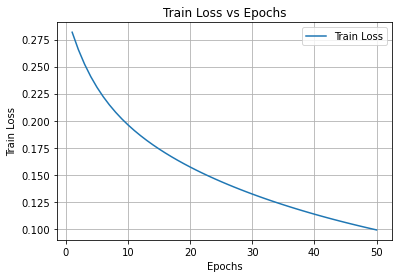

In [402]:
# Plotting epochs vs loss for train and test
import matplotlib.pyplot as plt
a = np.arange(1,epochs_ran+1)
fig, ax = plt.subplots()
ax.plot(a, x_train_loss, label="Train Loss")
ax.set(xlabel='Epochs', ylabel='Train Loss', title='Train Loss vs Epochs')
ax.grid()
ax.legend()
plt.show()

In [403]:
test_decisions = decisionfunction(sup_vecs, X_test, ga, inte, al)
svm_decs_test = svm.decision_function(X_test)
np.all(np.round(test_decisions, 7) == np.round(svm_decs_test, 7))

True

In [404]:
z = np.dot(w, test_decisions)+b
probs = sigmoid(z)

In [405]:
probs

array([0.13385582, 0.29156533, 0.1018878 , 0.35808861, 0.3954948 ,
       0.10959996, 0.05839708, 0.08207368, 0.08152214, 0.08951924,
       0.1859156 , 0.41801649, 0.12201321, 0.15457743, 0.05739113,
       0.08571344, 0.09371237, 0.09364462, 0.0654104 , 0.27326058,
       0.38997146, 0.06064207, 0.08453045, 0.21836567, 0.12282827,
       0.10095569, 0.12260564, 0.41363132, 0.08458481, 0.38490832,
       0.4420655 , 0.3980843 , 0.12146268, 0.1559306 , 0.42755251,
       0.17466094, 0.1287702 , 0.09594648, 0.37277592, 0.12586695,
       0.12126549, 0.45654096, 0.10557591, 0.21996947, 0.04337374,
       0.12169499, 0.13070478, 0.29184251, 0.0915997 , 0.14282808,
       0.14554533, 0.09871196, 0.12997662, 0.14261433, 0.3421417 ,
       0.37734608, 0.39576987, 0.07614196, 0.18149929, 0.13672746,
       0.07956011, 0.06705266, 0.41180968, 0.14335639, 0.08587174,
       0.11636723, 0.08873496, 0.39337254, 0.28396839, 0.07121417,
       0.09080868, 0.12789697, 0.12177496, 0.20061237, 0.24769

In [408]:
probs[probs > 0.5]

array([0.56038796, 0.50064381])